# **SPRINT 8**. Entrenament, evaluació i interpretació del model.

## **Llibreries i funcions auxiliars**

### Importació de les llibreries 

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

### Importació dels *datasets* ja preprocessats i separats en Test/Train


In [285]:
# Recuperem el fitxers ja preprocessats
FILEPATH = "../Data/bank_dataset_"
X_train = pd.read_csv(FILEPATH + "X_train.csv")
X_test = pd.read_csv(FILEPATH + "X_test.csv")
y_train = pd.read_csv(FILEPATH + "y_train.csv")
y_test = pd.read_csv(FILEPATH + "y_test.csv")    

### Revisió dels dataframes
- Durant la fase d'entrenament s'ha detectat que els fitxers CSV es van guardar mantenint la primera columna (index).
- Per evitar els errors i no tornar enrere, s'afegeix codi addicional per tal d'esborrar aquesta primera columna en els dataframes

In [286]:
# Comprovar que existeix aquesta primera columna no necessària
X_train.columns[0], X_test.columns[0], y_train.columns[0], y_test.columns[0]

('Unnamed: 0', 'Unnamed: 0', 'Unnamed: 0', 'Unnamed: 0')

In [287]:
# Eliminar la primera columna de cada dataframe i comprovar que s'ha fet correctament
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]
y_train = y_train.iloc[:, 1:]
y_test = y_test.iloc[:, 1:]

X_train.columns[0], X_test.columns[0], y_train.columns[0], y_test.columns[0]

('education', 'education', 'deposit', 'deposit')

### Defició de funció auxiliar `evaluate_model`
- Funció per avaluar el model i presentar els resultats
- La mètrica principal es `accuracy` ja que el dataset està balancejat i és una mètrica simple de entendre i comparar
- Les mètriques `precision`, `recall` i `f1-score` complementen la informació de `accuracy`.
- Sense mes informació per part del banc, es prioritzaran models amb la millor mètrica `accuracy` (percentatje total de encerts).
- També es verificarà que el model tingui una mètrica `recall` bona, ja que es la que recull els falsos negatius, es a dir, quan el model diu que no es contractarà el deposit, però no es cert i el banc perd la oportunidad de negoci.
- La mètrica `precision` té en compte els falsos positius, es a dir, quan el model diu que el client contractarà el diposit, pero en realitat no ho farà. En aquest cas, el banc ha consumit uns recursos per adreçar-se al client que no han estat efectius. Entenem que aquesta es una situació menys perjudicial que la de perdre l'oportunitat de negoci esmentada abans.   

In [303]:
# Definir funció per avaluar les mètriques de cada model i visualitzar els resultats
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    '''
    Funció per a avaluar les métriques de cada model
    Entrada:
        model_name: etiqueta amb el nom del model a avaluar
        model: model a avaluar
        X_train, X_test, y_train, y_test: datasets train i test
    Sortida:
        result: diccionari amb els resultats de l'avaluació del model
    '''
    
    # Calcular les prediccions dels datasets d'entrenament i de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Definir les mètriques 
    # Utilitzem average='macro' perquè el dataset no està desbalancejat
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred, average='macro', zero_division=0),
            'recall': recall_score(y_train, y_train_pred, average='macro', zero_division=0),
            'f1': f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_test_pred, average='macro', zero_division=0),
            'f1': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
        }
    }

    # Calcular i desar els resultats de l'avaluació
    result = {
        'train_metrics': metrics['train'],
        'test_metrics': metrics['test']
    }
    
    print(f"\nResultats del model {model_name}:")
    print(pd.DataFrame(result))

### Definició de funció auxiliar `plot_confusion_matrix`
- Calcular i visualizar la matriu de confusió per veure visualment el rendiment del model

In [289]:
def plot_confusion_matrix(model_name, model, X_test, y_test):
    '''
    Definir funció per dibuixar la matriu de confusió
    Entrada:
        model_name: etiqueta amb el nom del model avaluat
        model: model avaluat
        X_test, y_test: datasets de test
    '''

    # Calcular les prediccions
    y_test_pred = model.predict(X_test)
    
    # Definir i visualitzar gràfic
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

## **Entrenament dels models**

### Dummy Classifier
- Model básic de referencia: qualsevol altre model ha de superar el rendiment d'aquest model bàsic.

Entrenant DummyClassifier...

Resultats del model DummyClassifier:
           train_metrics  test_metrics
accuracy        0.526174      0.526127
precision       0.263087      0.263064
recall          0.500000      0.500000
f1              0.344767      0.344747


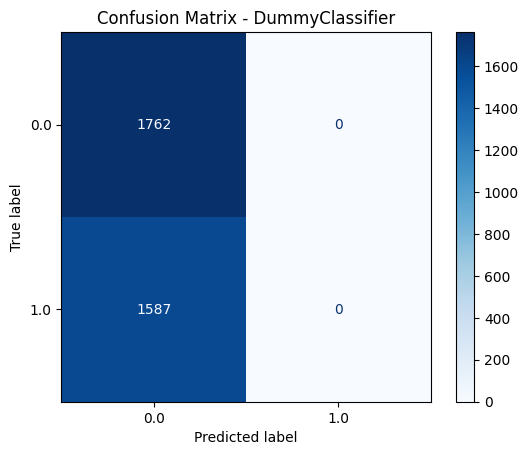

In [290]:
### DummyClassifier
model_name = "DummyClassifier"
print(f"Entrenant {model_name}...")
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
evaluate_model(model_name, dummy_model, X_train, X_test, y_train, y_test)
plot_confusion_matrix(model_name, dummy_model, X_test, y_test)

### Logistic Regression
- Utilitzant la funcionalitat `GridSearchCV' es busquen els hiper-paràmetres òptims del model.
- No totes les combinacions de hiper-paràmetres son vàlides i per tant tenim `warnings` que s'ignoren
- Aquest model requereix de l'aplicació de un escalat pel que fem servir `StandardScaler` dintre del Pipeline
- Resultats:
    - Les mètriques superen al model de referencia `DummyClassifier`, confirmant que el model ha estat capaç de deduir patrons
    dintre del dataset.
    - Les mètriques de `Test` son una mica pitjors que les de `Train`. Això es normal i confirma que no hi ha un sobreentrenament
    del model (overfitting)
    - El valors d'encert son bons però millorables, ja que s'equivoca en aproximadament un terç dels casos
    - El model funciona millor detectant el casos en que no es contracta el diposit (True Negative)
    - Resta espai per millorar el rendiment.
    - Es molt ràpid en processar el dataset.

Entrenant LogisticRegression...


Resultats del model LogisticRegression:
           train_metrics  test_metrics
accuracy        0.690644      0.678113
precision       0.691396      0.678989
recall          0.686938      0.674040
f1              0.687078      0.673937

Millors paràmetres: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


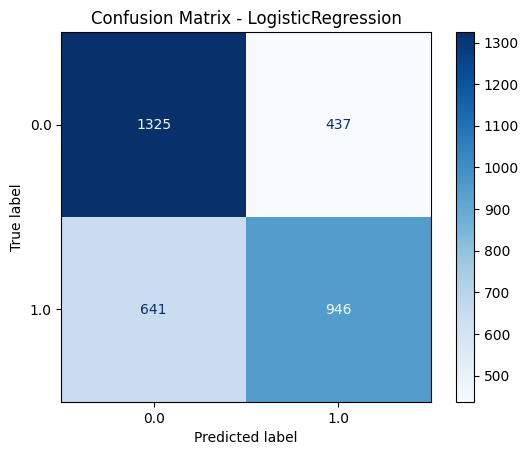

In [291]:
### LogisticRegression
model_name="LogisticRegression"
print(f"Entrenant {model_name}...\n")
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000))
])
lr_params = {
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
lr_model = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_params,
    scoring='accuracy',
    refit='accuracy',              
    cv=5,
    n_jobs=-1
)
lr_model.fit(X_train, y_train)
lr_eval = evaluate_model(model_name, lr_model, X_train, X_test, y_train, y_test)
print(f"\nMillors paràmetres: {lr_model.best_params_}")
plot_confusion_matrix(model_name, lr_model, X_test, y_test)


### SVC - Supported Vector Classifier
- Utilitzant la funcionalitat `GridSearchCV' es busquen els hiper-paràmetres òptims del model.
- Aquest model requereix de l'aplicació de un escalat pel que fem servir `StandardScaler` dintre del Pipeline
- Resultats:
    - Les mètriques superen al model de referencia `DummyClassifier`, confirmant que el model ha estat capaç de deduir patrons
    dintre del dataset.
    - També presenta un rendiment lleuregement superior al model de `LogisticRegression`
    - Les mètriques de `Test` son una mica pitjors que les de `Train`. Tot i que no son prou diferents com per sospitar de
    sobreentrenament, ja podem deduir que el model comença a capturar cert soroll de les dades d'entrenament. 
    - El valors d'encert son bons però millorables, ja que s'equivoca en gairabé un 30% dels casos
    - El model funciona millor detectant el casos en que no es contracta el diposit (True Negative)
    - Resta espai per millorar el rendiment.
    - El temps de processat del dataset es elevat, tipic d'aquests tipus de models

Entrenant SVC...

Resultats del model SVC:
           train_metrics  test_metrics
accuracy        0.740817      0.704688
precision       0.750744      0.712968
recall          0.734709      0.698231
f1              0.734426      0.696925

Millors paràmetres: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


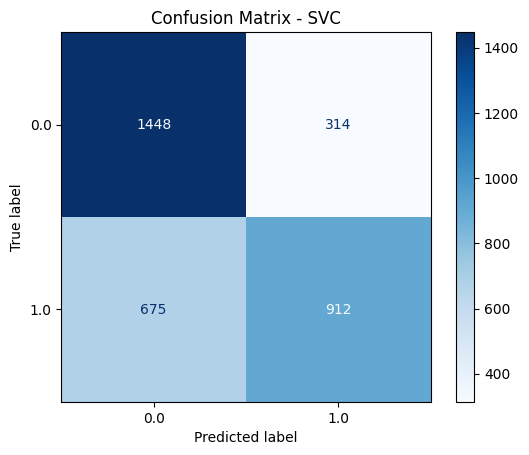

In [292]:
### SVC
model_name="SVC"
print(f"Entrenant {model_name}...")
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])
svc_params = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__gamma': ['scale', 'auto']
}
svc_model = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=svc_params,
    scoring='accuracy',
    refit='accuracy',
    cv=5,
    n_jobs=-1
)
svc_model.fit(X_train, y_train)
evaluate_model(model_name, svc_model, X_train, X_test, y_train, y_test)
print(f"\nMillors paràmetres: {svc_model.best_params_}")
plot_confusion_matrix(model_name, svc_model, X_test, y_test)

### Decision Tree Classifier
- Utilitzant la funcionalitat `GridSearchCV' es busquen els hiper-paràmetres òptims del model.
- Aquest model no requereix de l'aplicació de un escalat de les dades
- Resultats:
    - Les mètriques superen al model de referencia `DummyClassifier`, confirmant que el model ha estat capaç de deduir patrons
    dintre del dataset.
    - També presenta un rendiment lleuregement superior al model de `LogisticRegression`
    - Les mètriques de `Test` son una mica pitjors que les de `Train`. Tot i que no son prou diferents com per sospitar de
    sobreentrenament, ja podem deduir que el model comença a capturar cert soroll de les dades d'entrenament. 
    - El valors d'encert son bons però millorables, ja que s'equivoca en més un 30% dels casos
    - El model funciona millor detectant el casos en que no es contracta el diposit (True Negative)
    - Resta espai per millorar el rendiment.
    - El temps de processat del dataset es molt baix.

Entrenant DecisionTree...

Resultats del model DecisionTree:
           train_metrics  test_metrics
accuracy        0.719314      0.685876
precision       0.722482      0.687840
recall          0.714881      0.681324
f1              0.715066      0.681073

Millors paràmetres: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}


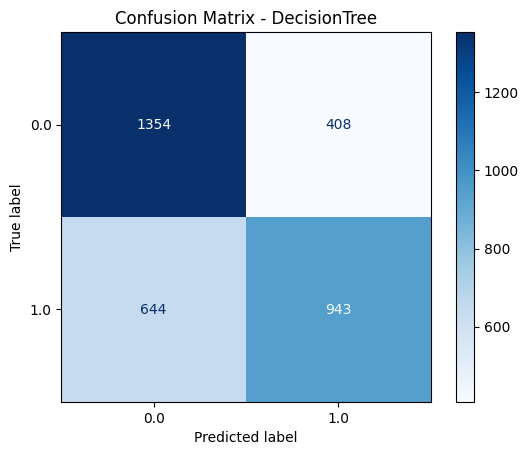

In [293]:
### DecisionTree
model_name="DecisionTree"
print(f"Entrenant {model_name}...")
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}
dt_model = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=dt_params,
    scoring='accuracy',
    refit='accuracy',
    cv=5,
    n_jobs=-1
)
dt_model.fit(X_train, y_train)
evaluate_model(model_name, dt_model, X_train, X_test, y_train, y_test)
print(f"\nMillors paràmetres: {dt_model.best_params_}")
plot_confusion_matrix(model_name, dt_model, X_test, y_test)

### Random Forest Classifier
- Utilitzant la funcionalitat `GridSearchCV' es busquen els hiper-paràmetres òptims del model.
- Aquest model no requereix de l'aplicació de un escalat de les dades.
- Resultats:
    - Les mètriques superen al model de referencia `DummyClassifier`, confirmant que el model ha estat capaç de deduir patrons
    dintre del dataset.
    - Presenta un rendiment similar al model de `SVC`
    - Les mètriques de `Test` son una mica pitjors que les de `Train`. Tot i que no son prou diferents com per sospitar de
    sobreentrenament, ja podem deduir que el model comença a capturar cert soroll de les dades d'entrenament. 
    - El valors d'encert son bons però millorables, ja que s'equivoca en prop del 30% dels casos
    - El model funciona millor detectant el casos en que no es contracta el diposit (True Negative)
    - Resta marge per millorar el rendiment.
    - El temps de processat del dataset es significatiu, tot que inferior a SVC.

Entrenant RandomForest...

Resultats del model RandomForest:
           train_metrics  test_metrics
accuracy        0.746448      0.707077
precision       0.751189      0.710924
recall          0.741902      0.702129
f1              0.742378      0.701932

Millors paràmetres: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


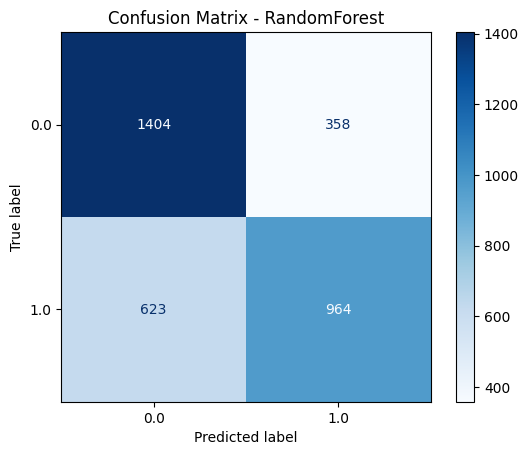

In [294]:
### RandomForest
model_name="RandomForest"
print(f"Entrenant {model_name}...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
rf_model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    scoring='accuracy',
    refit='accuracy',
    cv=5,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model(model_name, rf_model, X_train, X_test, y_train, y_test)
print(f"\nMillors paràmetres: {rf_model.best_params_}")
plot_confusion_matrix(model_name, rf_model, X_test, y_test)

### KNC - K-Neighbors Classifier
- Utilitzant la funcionalitat `GridSearchCV' es busquen els hiper-paràmetres òptims del model.
- Aquest model requereix de l'aplicació de un escalat de les dades, que s'incorpora al Pipeline
- Resultats:
    - Les mètriques superen al model de referencia `DummyClassifier`, confirmant que el model ha estat capaç de deduir patrons
    dintre del dataset.
    - També presenta un rendiment similar al model de `LogisticRegression`, amb majors diferencies entre mètriques de
    `Train` i `Test`.
    - Les mètriques de `Test` son una mica pitjors que les de `Train`. Tot i que no son prou diferents com per sospitar de
    sobreentrenament, ja podem deduir que el model comença a capturar cert soroll de les dades d'entrenament. 
    - El valors d'encert son bons però millorables, ja que s'equivoca en més del 30% dels casos
    - El model funciona millor detectant el casos en que no es contracta el diposit (True Negative)
    - Resta espai per millorar el rendiment.
    - El temps de processat del dataset es molt baix.

Entrenant KNC...

Resultats del model KNC:
           train_metrics  test_metrics
accuracy        0.732369      0.688265
precision       0.736070      0.690035
recall          0.727959      0.683876
f1              0.728301      0.683731

Millors paràmetres: {'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}


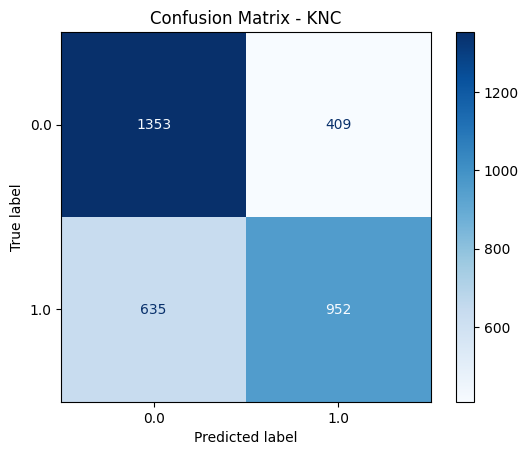

In [295]:
# KNC
model_name="KNC"
print(f"Entrenant {model_name}...")
knc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])
knc_params = {
    'model__n_neighbors': [3, 5, 10, 15, 20],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}
knc_model = GridSearchCV(
    estimator=knc_pipeline, 
    param_grid=knc_params, 
    cv=5, 
    scoring='accuracy', 
    refit='accuracy', 
    n_jobs=-1
)
knc_model.fit(X_train, y_train)
evaluate_model(model_name, knc_model, X_train, X_test, y_train, y_test)
print(f"\nMillors paràmetres: {knc_model.best_params_}")
plot_confusion_matrix(model_name, knc_model, X_test, y_test)

## **Conclusions i refinament del model**

### Conclusions
- Tots els models **han capturat patrons del dataset** d'entrenament i han presentar millors resultats que el model de referencia.
- Tots els models funcionen millor detectant els `True Negatives`, es a dir, quan no es contracta el diposit.
- `SVC` és el model que millor detecta els `True Negatives` 
- `RandomForest` és el model que millor detecta els `True Positives`, es a dir, quan encerta que es contractarà el diposit.
- `SVC` i `RandomForest` són els models que millor combinen la detecció dels `True Negatives` i dels `True Positives` (mètrica `accuracy`)
- Entre aquests dos models, seleccionem **`RandomForest` com a candidat a desplegar-se en producció** per les segëntes raons:
    - El seu rendiment es molt similar a SVC i el temps de entrenament es molt mes baix (de l'ordre de un terç)
    - Presenta un rati inferior en `FalseNegatives`, es a dir, casos en que el model prediu que no es contractarà el diposit, però en realitat el client si que està interessat.
    - Sense mes informació, prioritzem que el banc perdi menys oportunitats de negoci tot i que també suposarà un ús menys eficaç dels recursos de màrqueting ja que té un pitjor comportament en `FalsePositives`.
    - Aquest model també té el ventatge de que un cop entrenat podem consultar quines son les característiques mes rellevants llegint el valor de `feature_importances_` el que permet focalitzar en les caracteristiques que desprès el model més utilitza per aprendre.
- Tabla de mètriques RandomForest vs SVC:

    |            |     RandomForest    |         SVC         | 
    |------------|---------------------|---------------------|
    |            |   train  /   test   |   train  /   test   |
    | accuracy   | 0.746448 / 0.707077 | 0.740817 / 0.704688 |
    | precision  | 0.751189 / 0.710924 | 0.750744 / 0.712968 |
    | recall     | 0.741902 / 0.702129 | 0.734709 / 0.698231 |
    | f1         | 0.742378 / 0.701932 | 0.734426 / 0.696925 |
    

## **Refinament del model seleccionat**

### Millora del model Random Forest
- El model `RandomForest` seleccionat ja proporciona una **millora en la eficiencia** dels recursos de màrqueting del banc, predint correctament aproximadament un 70% dels casos (`accuracy = 0.70`). Tot i que es un valor significatiu, es considera que és baix i que **hi ha marge de millora**.
- Per tal de millorar el rendiment del model s'han utilitzat les dues següents opcions:
    1) Repetir l'optimització del hiper-paràmetres incrementant el `CrossValidation` de 5 a 10 (cv=10). El resultat es molt similar a l'entrenament amb cv=5 i el temps necessari puja signficativament.
    2) Tornar a entrenar el model RandomForest amb mes dades, fent un split Train/Test diferent del dataset senser (90/10) i utilitzar els hiper-paràmetres òptims calculats per `GridSearchCV`. El resultat novament es una millora (la mètrica `accuracy` de Test s'incrementa fins a 0.73 i `recall` gairebé fins a 0.74). Es també important destacar que la diferencia entre les mètriques de Train i Test es ara molt baixa, confirmant que **el model ha estat capaç de capturar els patrons de les dades i no el soroll**. 
- Resum de les mètriques del tres models basats en RandomForest:

    |            |     RandomForest    |  RandomForest cv10  | RandomForest 90/10  |
    |------------|---------------------|---------------------|---------------------|
    |            |   train  /   test   |   train  /   test   |   train  /   test   |
    | accuracy   | 0.746448 / 0.707077 | 0.740561 / 0.704688 | 0.738676 / 0.733214 |
    | precision  | 0.751189 / 0.710924 | 0.744613 / 0.708502 | 0.744513 / 0.739064 |
    | recall     | 0.741902 / 0.702129 | 0.736159 / 0.699702 | 0.733645 / 0.728010 |
    | f1         | 0.742378 / 0.701932 | 0.736600 / 0.699453 | 0.733855 / 0.728113 |
    
- L'última opció que restaria (no s'ha provat) és tornar a les fases d'exploració de dades (EDA), reducció de dimensionalitat i selecció de caracteristiques, fent una anàlisi mes acurada (i diferent) per tal de disposar de més informació que permiti detectar els patrons i eliminar dades que puguin introducir soroll.
- Finalment, **el model que seleccionat per desplegar en producció es RandomForest amb Train/Test 90/10 i els hiper-paràmetres òptims calculats previament amb `SearchGridCV`**
- Un cop desplegat aquest model, el banc podrà utilitzar-lo per tal de **focalitzar els recursos de negoci i marketing en els clients que el model detecti que amb mes probabilitat contractaran el diposit**. Així mateix, evitaràn adreçar-se a clients que no contractaran el diposit. Tot i que no serà un model perfecte, representarà una gran **millora en la gestió i eficiencia dels recursos dedicats a captar nous diposits**, comparat amb el sistema utilitzats en campanyes anteriors (si n'hi havia)

Entrenant RandomForest-cv10...

Resultats del model RandomForest-cv10:
           train_metrics  test_metrics
accuracy        0.740561      0.704688
precision       0.744613      0.708502
recall          0.736159      0.699702
f1              0.736600      0.699453

Millors paràmetres: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


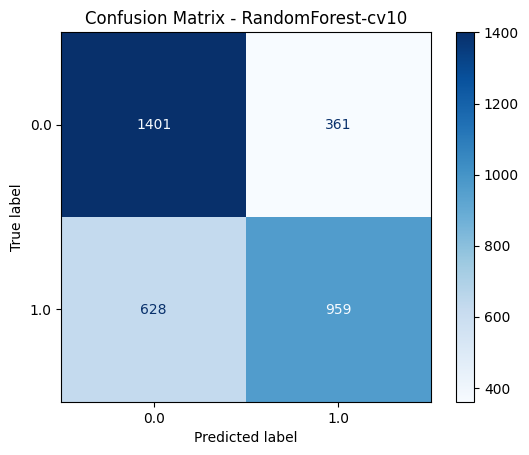

In [296]:
### RandomForest amb cv=10
model_name="RandomForest-cv10"
print(f"Entrenant {model_name}...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
rf_model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    scoring='accuracy',
    refit='accuracy',
    cv=10,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model(model_name, rf_model, X_train, X_test, y_train, y_test)
print(f"\nMillors paràmetres: {rf_model.best_params_}")
plot_confusion_matrix(model_name, rf_model, X_test, y_test)


Resultats del model RandomForest-T90:
           train_metrics  test_metrics
accuracy        0.738676      0.733214
precision       0.744513      0.739064
recall          0.733645      0.728010
f1              0.733855      0.728113


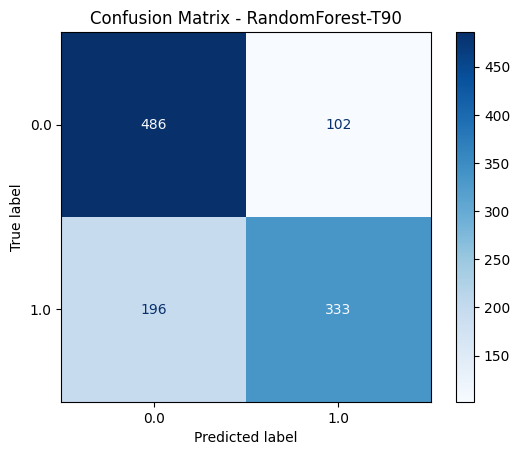

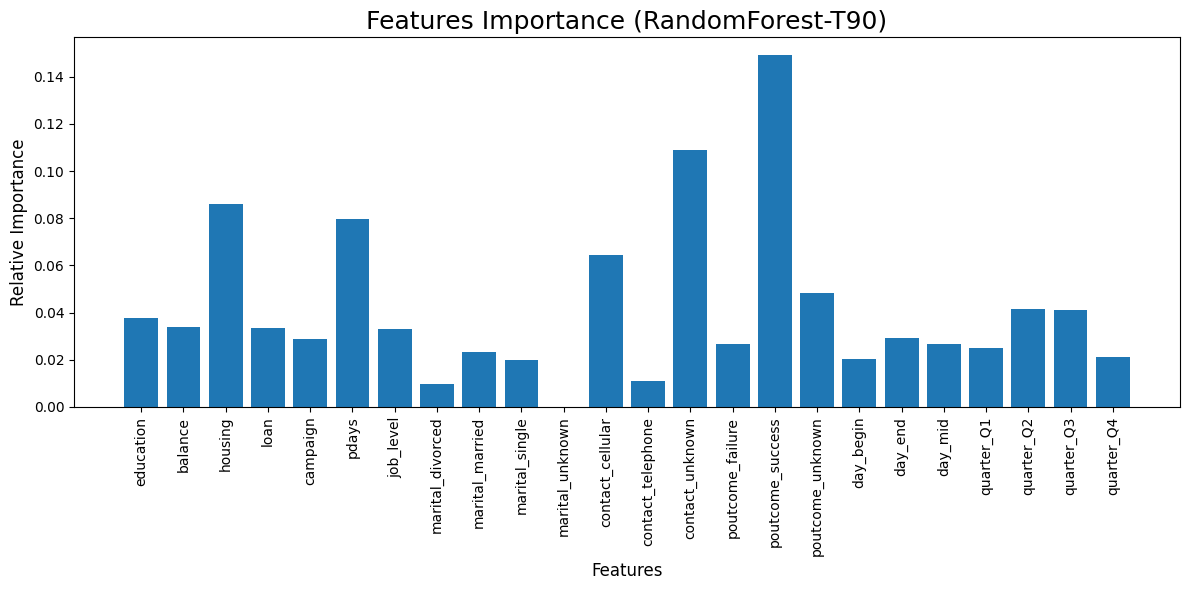

In [300]:
from sklearn.model_selection import train_test_split

model_name="RandomForest-T90"

X = pd.concat([X_train, X_test],axis=0)
y = pd.concat([y_train, y_test],axis=0)

# Separem en Train/Test les entrades i la variable objectiu (ara amb només el 10% de Test)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Utilitzem els hiperparàmetres òptims calculats per 'GridSearchCV' amb cv=5
# {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
rf_model_2 = RandomForestClassifier(
    n_estimators=100,
    criterion='gini', 
    max_depth=10, 
    min_samples_split=10,
    min_samples_leaf=2,
    n_jobs=-1
)
rf_model_2.fit(X_train2, y_train2)
evaluate_model(model_name, rf_model_2, X_train2, X_test2, y_train2, y_test2)
# print(f"\nMillors paràmetres: {rf_model_2.best_params_}")
plot_confusion_matrix(model_name, rf_model_2, X_test2, y_test2)

# Plot de les caracteristiques mes importants considerades per el model durant l'entrenament
plt.figure(figsize=(12, 6))
plt.bar(range(len(rf_model_2.feature_importances_)), rf_model_2.feature_importances_)
plt.xticks(range(len(rf_model_2.feature_importances_)), X_train2.columns, rotation=90)
plt.title(f"Features Importance ({model_name})", fontsize=18)
plt.ylabel("Relative Importance", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.tight_layout()
plt.show() 


## **Desar el model seleccionat**
- Desem el model seleccionat en format `pickle` per utilitzar-lo mes endavant.
- El model seleccionat no necessita escalat i per tant no cal desar-ho.

In [302]:
# Desar el model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model_2, f)